<a href="https://colab.research.google.com/github/GustavoBD-Dev/ThesisProjectDDRUCNN/blob/main/ThesisProjectDDRUCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detección de Retinopatia Diabetica utilizando Redes Neuronales Convolucionales

## Set de datos

El conjunto de imagenes de obtiene de Kaggle, se proporciona un archivo comprimido `archive.zip`, que contiene una carpeta con mas de 35000 imagenes y un archivo `trainLabels.csv` el cual contiene la información del set de datos. 

In [2]:
# Importamos todas las librerias necesarias
import numpy as np
import pandas as pd
import os
import cv2
from google.colab import files # load file

In [3]:
# Carga del archivo csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving trainLabels.csv to trainLabels.csv
User uploaded file "trainLabels.csv" with length 465317 bytes


## Analisis de datos

Realizamos la lectura del archivo `csv`, mostramos el encabezado del archivo, al realizar la lectura del archivo con la libreria `pandas` de puede tratar como un dataset.

In [4]:
# Lectura del archivo csv
data = pd.read_csv('trainLabels.csv')
# Mostramos encabezado del archivo
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


El dataset contiene dos columnas `[image]` y `[level]`, la columna `image` contiene el nombre de la imagen sin extención del archivo y la columna `level` corresponde a la etiqueta con el nivel de RD que se le a asignado. Realizamos una grafica para mostrar el balanceo de los datos.

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

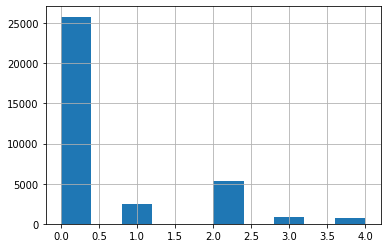

In [5]:
data['level'].hist()
data['level'].value_counts()

In [6]:
# agregamos jpeg a cada valor de image para relacionarlo con las imagenes del dataset
# se guarda en una nueva columna
data['image_name'] = [i + '.jpeg' for i in data['image'].values]
print(data.head())
print('\n')

      image  level     image_name
0   10_left      0   10_left.jpeg
1  10_right      0  10_right.jpeg
2   13_left      0   13_left.jpeg
3  13_right      0  13_right.jpeg
4   15_left      1   15_left.jpeg




## Balanceo de los datos

Como podemos ver en la grafica que corresponde al total de datos por clase, las clases se encuentran desbalanceadas, el minimo de imagenes de las clases es de 708. Se debe realizar un balanceo de las clases, se ha optado por eliminar las imagenes de las clases restantes, con el fin de tener el mismo numero de imagenes por cada clase. En este caso se obtendran 700 imagenes de cada clase, de aqui se obtendran las imagenes para el entrenamiento y prueba de la red.

In [ ]:
#Importamos archivo CSV como DataFrame
import pandas as pd # para manejar los dataset 
import shutil # para mover los archivos
import csv

# Lectura y vizualizacion del archivo CSV con las etiquetas
data = pd.read_csv('trainLabels.csv')
print(data.head())
print('\n')

# agregamos jpeg a cada valor de image para relacionarlo con las imagenes del dataset
# se guarda en una nueva columna
data['image_name'] = [i + '.jpeg' for i in data['image'].values]
print(data.head())
print('\n')

# Debemos obtener el mismo numero de imagenes en cada clase para balancear la data
levels = {
    'level_0':0, 
    'level_1':0, 
    'level_2':0, 
    'level_3':0, 
    'level_4':0, }
images = [] # nombre de las imagenes
images_name = [] # guarda el nombre de las imagenes con extención 'jpeg'
labels = [] # guarga la etiqueta correpondiente al nombre en images

# Recorremos el DataFrame analizando el atributo 'level' de los datos
for i in data.index:
    # Recorremos los 5 nivels de RD
    for j in [0,1,2,3,4]:
        # Buscamos el nivel de RD del DataSet
        if data['level'][i] == j: # encuentra el nivel de RD 
            # si no tenemos completos los datos de esa clase se agrega 
            if levels['level_{}'.format(j)] < 700:
                # copiamos la imagen a la carpeta final (train)
                shutil.copy('resized_train/resized_train/{}'.format(data['image_name'][i]), "train/{}".format(data['image_name'][i]))
                # incrementamos el valor de los datos de las clases en el diccionario
                levels['level_{}'.format(j)]+=1
                # agregamos el nombre de la imagen y el nivel
                images.append(data['image'][i])
                images_name.append(data['image_name'][i])
                labels.append(j)

print(levels)
print(images)
print(labels)

with open('trainLabelsBalanced.csv', 'w+', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(['image','level', 'image_name'])
    for i in range(len(images)):
        writer.writerow([images[i], labels[i], images_name[i]])

print('Fin del programa')

Analizamos el archivo `csv` que se ha generado con los nuevos datos, para revisar el balanceo de clases.

In [4]:
# Lectura del archivo csv
dataClean = pd.read_csv('trainLabelsBalanced.csv')
# Mostramos encabezado del archivo
dataClean.head()

,image,level,image_name
0,10_left,0,10_left.jpeg
1,10_right,0,10_right.jpeg
2,13_left,0,13_left.jpeg
3,13_right,0,13_right.jpeg
4,15_left,1,15_left.jpeg


3    700
1    700
4    700
2    700
0    700
Name: level, dtype: int64

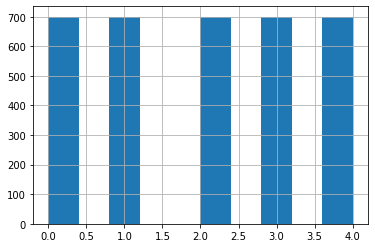

In [5]:
dataClean['level'].hist()
dataClean['level'].value_counts()

## Visualización de los datos

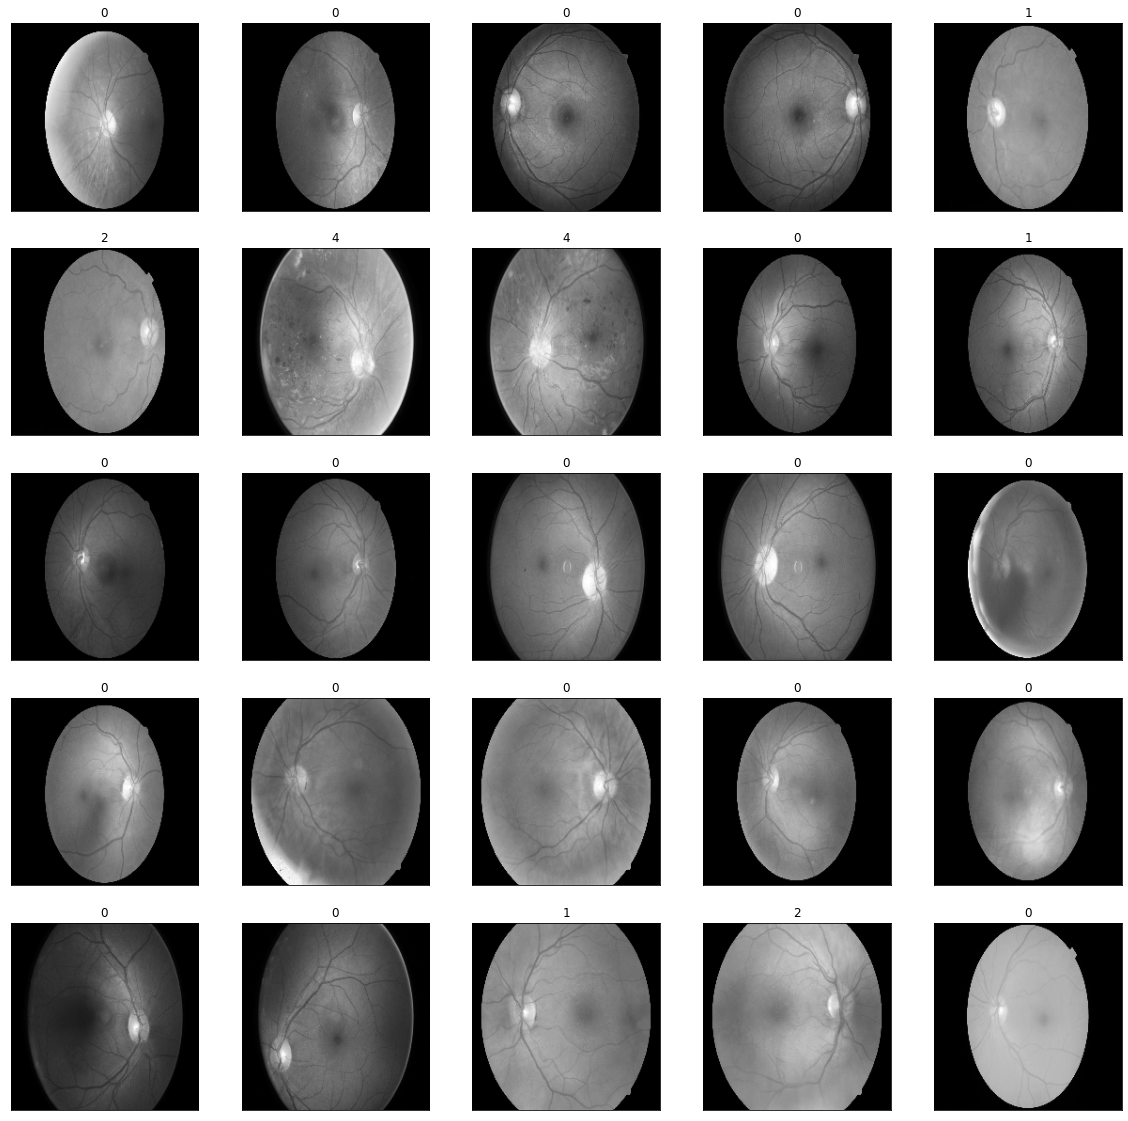

In [8]:
import cv2
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
#dimension de la imagen
TAMANIO_IMG = 200

for i in range(0,25):# len(dataClean['image_name'])):
  image = cv2.imread( 'train/' + dataClean['image_name'][i])
  image = cv2.resize(image,(TAMANIO_IMG, TAMANIO_IMG))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  plt.subplot(5, 5, i+1)
  plt.title(dataClean['level'][i])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image, cmap='gray')


##Datos de entrenamiento y datos de prueba

Se tienen 700 datos de cada clase, por lo que se tomaran 600 imagenes para el entrenamiento del modelo y 100 restantes para el set de prueba, hacemos la separacion de los datos, agregamos la etiqueta a cada imagen, esto dentro del archivo `csv` para despues leerlo nuevamente como un dataframe.

In [13]:
#Importamos archivo CSV como DataFrame
import matplotlib.pyplot as plt
import pandas as pd # para manejar los dataset 
import shutil # para mover los archivos
import csv

# Lectura y vizualizacion del archivo CSV con las etiquetas
data = pd.read_csv('trainLabelsBalanced.csv')
print(data.head())
print('\n')

# se muestran las clases balanceadas
#data['level'].hist()
#data['level'].value_counts()
#plt.show()

# Debemos obtener el mismo numero de imagenes en cada clase para balancear la data
levels = {
    'level_0':0, 
    'level_1':0, 
    'level_2':0, 
    'level_3':0, 
    'level_4':0, }
images = [] # nombre de las imagenes
images_name = [] # guarda el nombre de las imagenes con extención 'jpeg'
labels = [] # guarga la etiqueta correpondiente al nombre en images
train_test = [] #guarda la etiqueta con el nombre del set al que pertence


# Recorremos el DataFrame analizando el atributo 'level' de los datos
for i in data.index:
    # Recorremos los 5 nivels de RD
    for j in [0,1,2,3,4]:
        # Buscamos el nivel de RD del DataSet
        if data['level'][i] == j: # encuentra el nivel de RD 
            # si no tenemos completos los datos de esa clase se agrega 
            if levels['level_{}'.format(j)] < 600:
                # se asigna a set para entrenamiento
                train_test.append('train')
            else:
                # se asigna a set para prueba
                train_test.append('test')

            # incrementamos el valor de los datos de las clases en el diccionario
            levels['level_{}'.format(j)]+=1
            # agregamos el nombre de la imagen y el nivel
            images.append(data['image'][i])
            images_name.append(data['image_name'][i])
            labels.append(j)

with open('trainLabelsBalanced.csv', 'w+', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(['image','level', 'image_name'])
    for i in range(len(images)):
        writer.writerow([images[i], labels[i], images_name[i], train_test[i]])

# Lectura del archivo csv
dataClean = pd.read_csv('trainLabelsBalanced.csv')
# Mostramos encabezado del archivo
dataClean.head()

print('Fin del programa')

          image          level image_name
10_left       0   10_left.jpeg      train
10_right      0  10_right.jpeg      train
13_left       0   13_left.jpeg      train
13_right      0  13_right.jpeg      train
15_left       1   15_left.jpeg      train


Fin del programa
